# Overview:
Our goal is to answer some basic questions about the movie industry and make recommendations based on our findings. 

First, we set out to learn a few basic things from our data- budgets, gross and net profit, which will inform our choices. 

Next, we examine various factors and look for correlations between them and profit. The factors we focused on most are genre, release date, run time and rating.

By isolating the factors that had the most positive correlation to profit, we are able to combine them and look for the most likely scenarios to generate returns, and how much to weigh each of our recommendations.

### Importing Libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import requests
import sys
import time
from bs4 import BeautifulSoup
import func

In [2]:
name_basics = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
title_akas = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
title_basics = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
title_ratings = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
movie_info= pd.read_csv('./zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews= pd.read_csv('./zippedData/rt.reviews.tsv.gz', sep='\t', encoding='windows-1254')
budgets = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
freshrating = pd.read_csv('./freshrating.csv')

### Data cleaning, ordering and merging the datasets

Working with the budgets dataset- the most complete of our sheets at a glance, but missing values are represented as 0, so on a closer look we had to drop a lot of incomplete rows.

In [3]:
#converting all the money columns to ints and removing $

budgets.worldwide_gross = func.money_to_int(budgets.worldwide_gross)

budgets.domestic_gross = func.money_to_int(budgets.domestic_gross)

budgets.production_budget = func.money_to_int(budgets.production_budget)


#converting dates to datetime

budgets.release_date = func.col_datetime(budgets.release_date)


In [4]:
#creating columns for net and ROI

budgets['worldwide_net'] = func.calculate_net(budgets.worldwide_gross, budgets.production_budget)

budgets['profit_percentage'] = func.calculate_roi(budgets.worldwide_net, budgets.production_budget)


#renaming title column for a future merge

budgets.rename(columns= {'movie': 'primary_title'}, inplace= True)


#removing rows with release dates before 2000

budgets = func.release_window(budgets, 'release_date')

We merged the two IMDb sheets that seemed the most relevant to our questions, which allowed us to pull genre, rating and title information. 

In [5]:
#merging the sheets, dropping NaN values and seperating genres into lists

titlerate = title_ratings.merge(title_basics, on= 'tconst')

titlerate.dropna(subset= ['averagerating'], inplace = True)

titlerate.dropna(subset = ['genres'], inplace = True)

titlerate.genres = func.genre_convert(titlerate.genres)

The movie_info Rotten Tomatoes dataset proved far more useful than the wildly incomplete rt_reviews - since it includes revenue, dates, and genres. Unfortunately it does not include titles, which forced us to use it independently.

In [6]:
#converting dates to datetime, removing old movies and dropping the dvd date column

movie_info['theater_date'] = func.col_datetime(movie_info['theater_date'])

movie_info[~movie_info['theater_date'].isin(pd.date_range(start='1915-01-01', end= '1999-12-31'))]

movie_info.drop(['dvd_date'], axis = 1, inplace = True)

movie_info['box_office'] = movie_info['box_office'].str.replace(',','')

In [7]:
#splitting the genres in movie info

movie_info['genres']=movie_info.genre.apply(lambda x: re.split("and|\|",x) if isinstance(x,str) else x)


#dropping NAs from genres

movie_info.dropna(subset = ['genres'], inplace = True)

Finally, we merged the IMDb and budgets datasets to produce our most comprehensive sheet.

In [8]:
# merging the cleaned dataframes
maindf = budgets.merge(titlerate, on= 'primary_title', how= 'inner')

### Web Scraping

Because the Rotten Tomatoes datasets didn't include titles, we decided to scrape data from the internet and apply the ratings to the merged IMDb and budget tables- yeilding the most complete possible merge of the groups.

First we create a series of properly formatted titles to feed into the scrape function.

In [9]:
# reformatting the title column to be inserted into a url

title_series = maindf.original_title.str.replace(' ', '_')

Then we run the function and save the output to csv.

In [12]:
# # this is commented out to avoid a long wait while the scrape function renders

# fresh_scores = func.scrape(title_series)

# # converting the returned dictionary to a series

# fresh_scores = pd.Series(fresh_scores)

# # converting the titles back to the format in maindf

# fresh_scores.primary_title = test.primary_title.str.replace('_', ' ')

# # saving as a csv file

# fresh_scores.to_csv('./freshrating.csv')

In [10]:
#now we can merge the datasets into a new df- though smaller, it's now the most comprehensive set 

df = maindf.merge(freshrating, on= 'primary_title', how = 'inner')

df.rating = df.rating.str.replace('%', '')

df.rating = df.rating.astype(int)

### Visualizations and Examining the Datasets

#### Part 1: Ratings vs. Gross and Profit

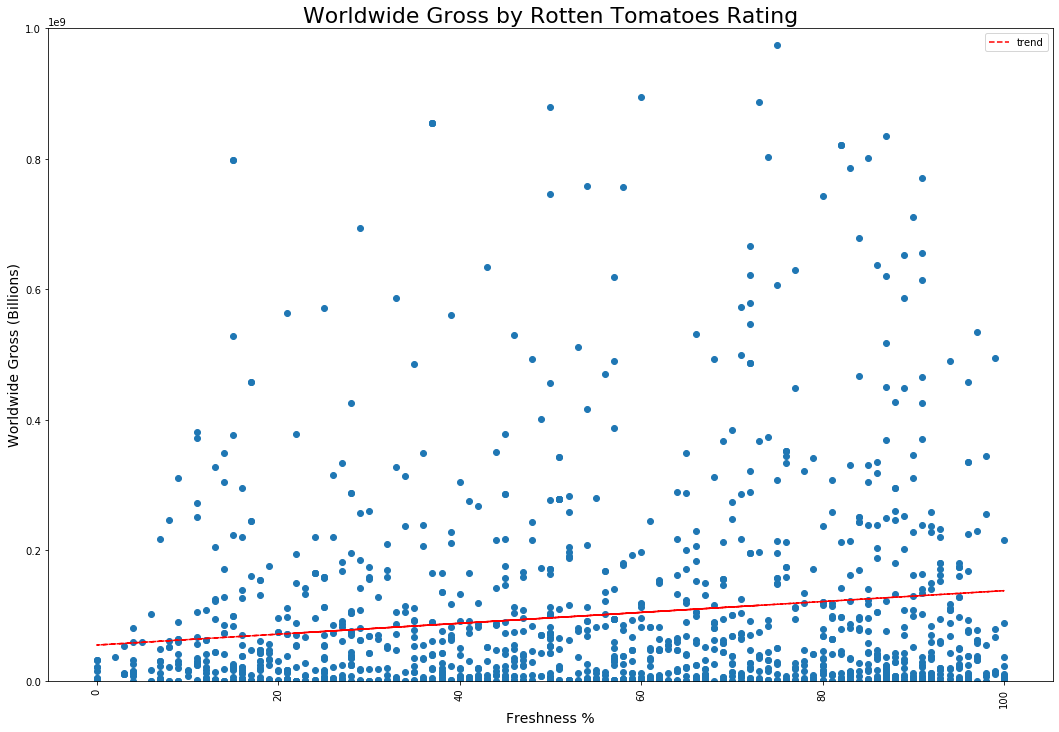

In [14]:
#there is a slight positive correlation between rating and gross
fig, ax = plt.subplots(figsize= (18, 12))
x= df.rating
y= df.worldwide_gross 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", label='trend')
ax.set_xlabel('Freshness %', fontsize=14)
ax.set_ylabel('Worldwide Gross (Billions)', fontsize= 14)
ax.set_ylim(0, 1000000000)
plt.xticks(rotation= 90)
plt.scatter(x, y)
ax.set_title('Worldwide Gross by Rotten Tomatoes Rating', fontsize= 22)
plt.legend(loc='upper right')

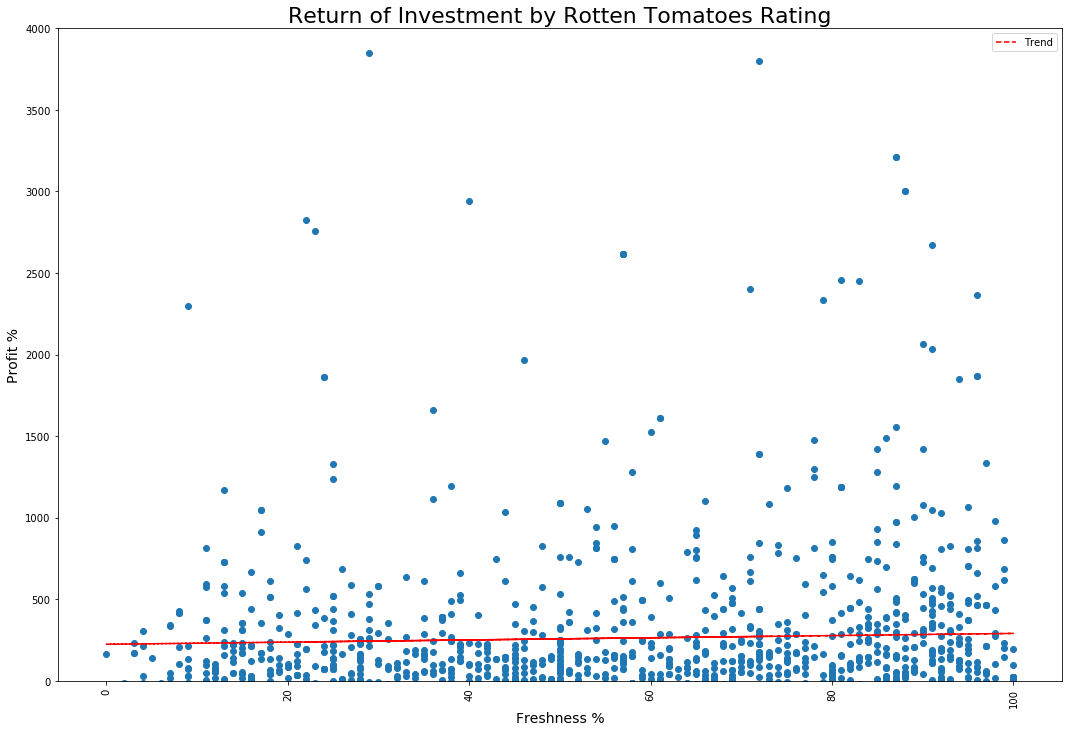

In [15]:
#profitability based on rating has a near zero correlation, on the other hand
fig, ax = plt.subplots(figsize= (18, 12))
x= df.rating
y= df.profit_percentage 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", label = 'Trend')
ax.set_xlabel('Freshness %', fontsize= 14)
ax.set_ylabel('Profit %', fontsize= 14)
ax.set_ylim(0, 4000)
plt.xticks(rotation= 90)
plt.scatter(x, y)
ax.set_title('Return of Investment by Rotten Tomatoes Rating', fontsize=22)
plt.legend(loc= 'upper right')

In [14]:
df.corrwith(df.rating)

id                   0.003522
production_budget    0.021491
domestic_gross       0.136906
worldwide_gross      0.120613
domestic_net         0.171319
worldwide_net        0.137705
profit_percentage    0.014987
averagerating        0.457955
numvotes             0.226163
start_year           0.030103
runtime_minutes      0.165205
Unnamed: 0           0.031576
rating               1.000000
dtype: float64

#### Part 2: Release Date vs. Gross and Profit

Text(0.5, 1.0, 'Worldwide Gross by Release Date')

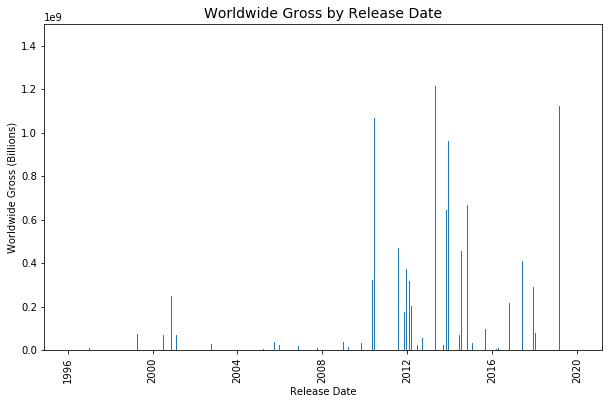

In [16]:
#plotting worldwide gross for our selected time period. There are some pretty obvious peaks and valleys, just need to get into the year over year and follow the trends. I cropped out the outlier data above $1.5bn to show more granular spread 
fig, ax = plt.subplots(figsize= (10, 6))
x= maindf['release_date']
y= maindf.worldwide_gross 

ax.set_xlabel('Release Date')
ax.set_ylabel('Worldwide Gross (Billions)')
ax.set_ylim(0, 1500000000)
plt.xticks(rotation= 90)
plt.bar(x, y)
ax.set_title('Worldwide Gross by Release Date', fontsize=14)

In [17]:
#calculating monthly average profit percentage to see which month is most profitable
maindf_monthnet = maindf.groupby(maindf['release_date'].dt.strftime('%m%B'))['profit_percentage'].mean().sort_index()

Text(0.5, 1.0, 'Return of Investment by Release Month')

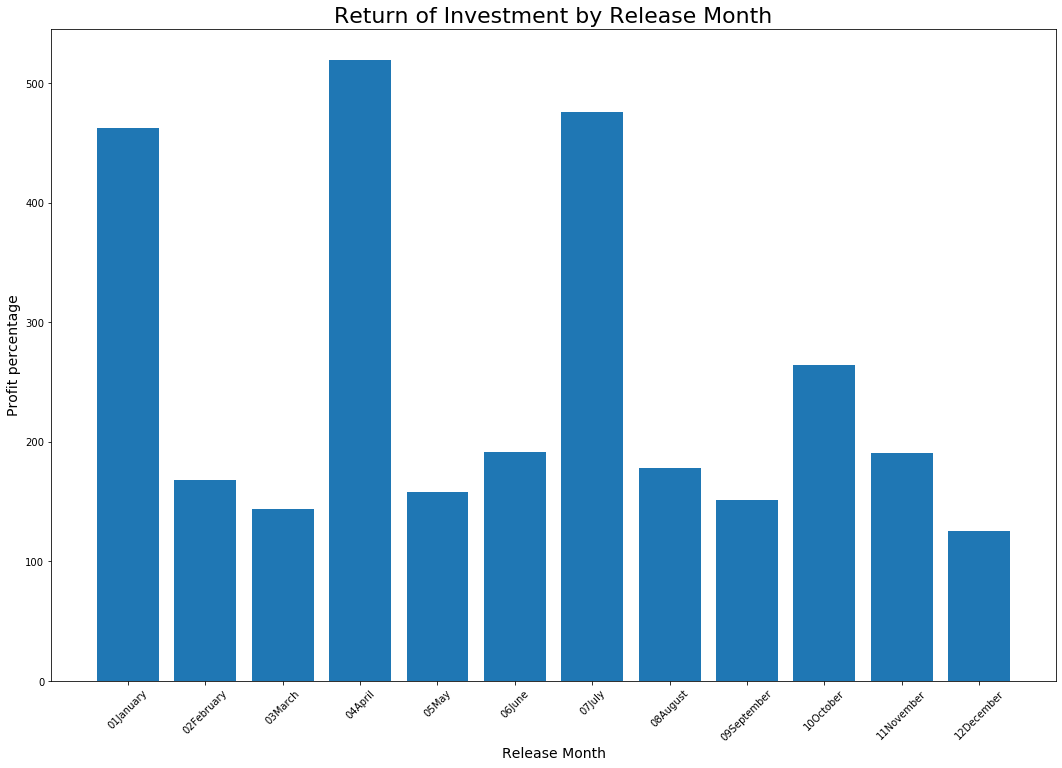

In [18]:
#Here we can see there are some definite peak months- we can conclude the best months to release films for profitability are January, April, July and October
fig, ax = plt.subplots(figsize= (18, 12))
x= maindf_monthnet.keys()
y= maindf_monthnet

ax.set_xlabel('Release Month', fontsize = 14)
ax.set_ylabel('Profit percentage', fontsize = 14)
plt.xticks(rotation= 45)
plt.bar(x,y)
ax.set_title('Return of Investment by Release Month', fontsize=22)

#### Part 3: Runtime vs. Profit

Text(0.5, 1.0, 'Return of Investment by Runtime (minutes)')

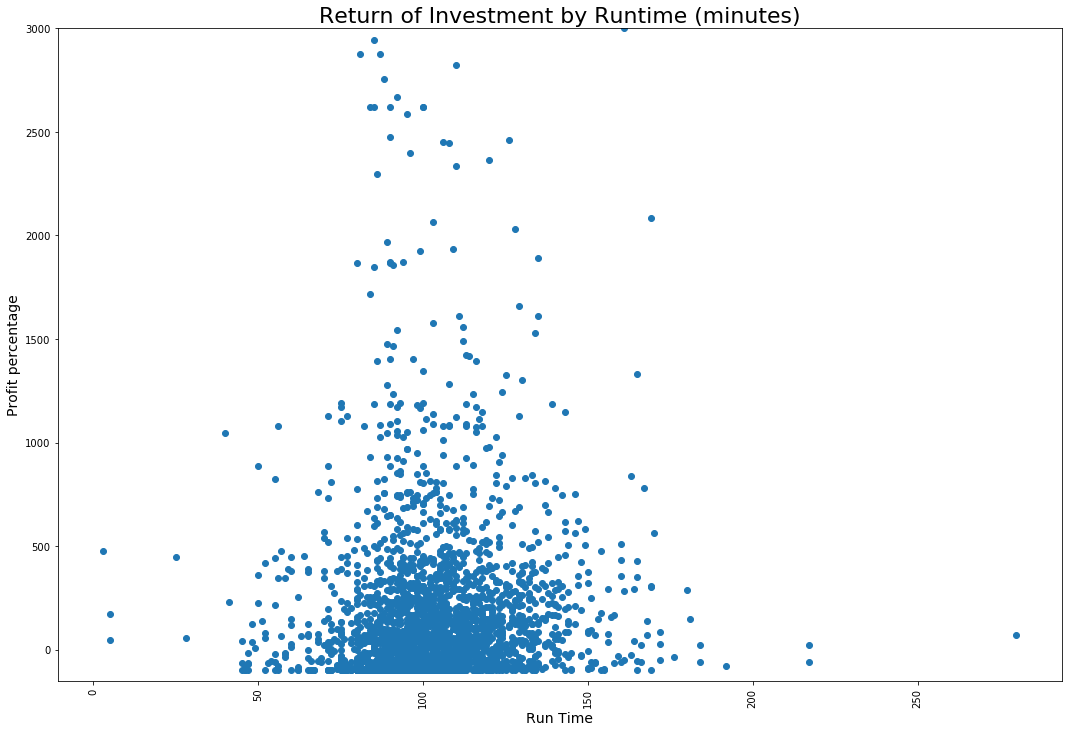

In [19]:
#plotting runtime vs profit percentage to see if there's an ideal movie length, overall looks like there's no correlation
fig, ax = plt.subplots(figsize= (18, 12))
x= maindf['runtime_minutes']
y= maindf.profit_percentage
ax.set_xlabel('Run Time', fontsize = 14)
ax.set_ylabel('Profit percentage', fontsize = 14)
plt.xticks(rotation= 90)
ax.set_ylim(-150, 3000)
plt.scatter(x,y)
ax.set_title('Return of Investment by Runtime (minutes)', fontsize = 22)

In [22]:
maindf.corrwith(maindf['runtime_minutes'])

id                  -0.038877
production_budget    0.253305
domestic_gross       0.196927
worldwide_gross      0.211170
domestic_net         0.046943
worldwide_net        0.183077
profit_percentage   -0.014817
averagerating        0.225979
numvotes             0.372349
start_year           0.070643
runtime_minutes      1.000000
dtype: float64

#### Part 4: Budget vs. Profit

In [20]:
#here we see there is no correlation between initial production budget and profitability, but there are a lot of outliers in our dataset. As mentioned above, the budgets sheet contained a lot of zero values as placeholders, so we worked on a succession of graphs to show the removal of outlier data.
maindf.corrwith(maindf['production_budget'])

id                  -0.043503
production_budget    1.000000
domestic_gross       0.732088
worldwide_gross      0.786046
domestic_net         0.126647
worldwide_net        0.665985
profit_percentage   -0.031227
averagerating        0.135606
numvotes             0.505046
start_year           0.034041
runtime_minutes      0.253305
dtype: float64

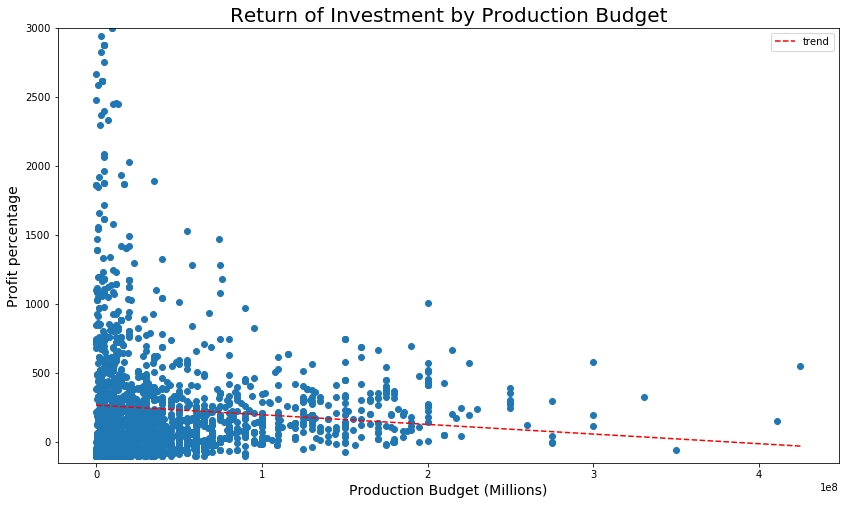

In [22]:
#plotting production budget vs. profit percentage to find ideal sweet spot of budget spent vs profit returned
fig, ax = plt.subplots(figsize= (14, 8))
x= maindf['production_budget']
y= maindf.profit_percentage
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--", label = 'trend')
ax.set_xlabel('Production Budget (Millions)', fontsize = 14)
ax.set_ylabel('Profit percentage', fontsize = 14)
ax.set_ylim(-150, 3000)
plt.scatter(x,y)
ax.set_title('Return of Investment by Production Budget', fontsize = 20)
plt.legend(loc= 'upper right')
#let's clean up the outlier data here and see if there's a clearer picture

In [23]:
#creating copies of our maindf cleared out outlier data and with ~70% of central weighted data for the budget column
maindf_1 = pd.DataFrame(maindf)
maindf_1['production_budget'] = maindf_1['production_budget'].sort_values()[150:2500]
maindf_1.dropna(subset= ['production_budget'], inplace = True)

maindf_2 = pd.DataFrame(maindf)
maindf_2['production_budget'] = maindf_2['production_budget'].sort_values()[600:2100]
maindf_2.dropna(subset = ['production_budget'], inplace = True)

By clearing the outlier data successively we see the trend line flattening. Our conclusion is that by spending less than $50 million in initial budget, you signigicantly reduce the likelihood of running a loss percentage.

No handles with labels found to put in legend.


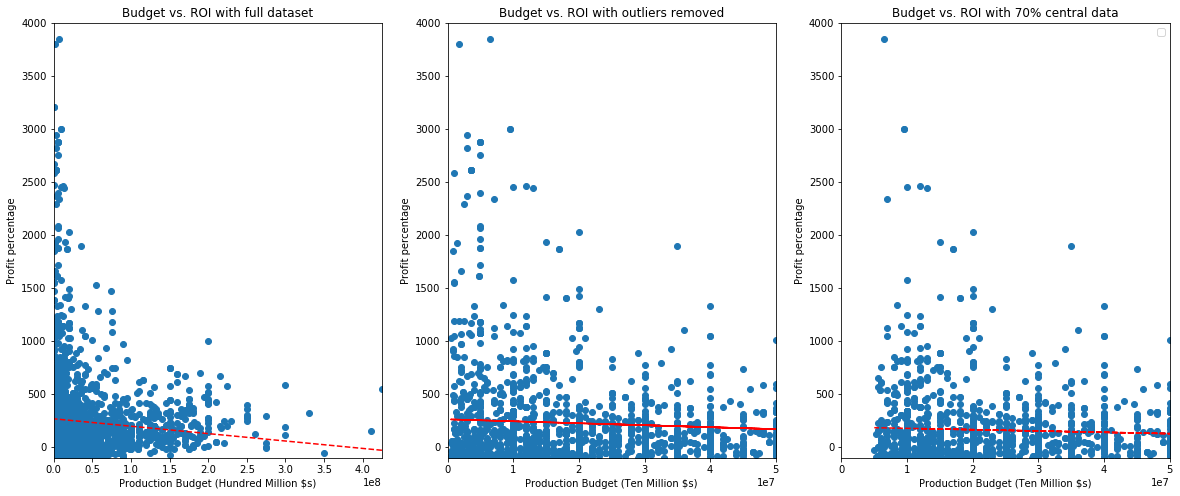

In [24]:
budget_fig = plt.figure(figsize= (20, 8))

ax = budget_fig.add_subplot(131)
ax1 = budget_fig.add_subplot(132)
ax2 = budget_fig.add_subplot(133)

z = np.polyfit(maindf.production_budget, maindf.profit_percentage, 1)
z1= np.polyfit(maindf_1.production_budget, maindf_1.profit_percentage, 1)
z2= np.polyfit(maindf_2.production_budget, maindf_2.profit_percentage, 1)
p = np.poly1d(z)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)

ax.scatter(maindf.production_budget, maindf.profit_percentage)
ax.plot(maindf.production_budget, p(maindf.production_budget),"r--")

ax1.scatter(maindf_1.production_budget, maindf_1.profit_percentage)
ax1.plot(maindf_1.production_budget, p1(maindf_1.production_budget),"r--")

ax2.scatter(maindf_2.production_budget, maindf_2.profit_percentage)
ax2.plot(maindf_2.production_budget, p2(maindf_2.production_budget),"r--")

ax.set_ylim(-100, 4000)
ax1.set_ylim(-100, 4000)
ax2.set_ylim(-100, 4000)
ax.set_xlim(0, 425000000)
ax1.set_xlim(0, 50000000)
ax2.set_xlim(0, 50000000)

ax.set_title('Budget vs. ROI with full dataset')
ax1.set_title('Budget vs. ROI with outliers removed')
ax2.set_title('Budget vs. ROI with 70% central data')

ax.set_xlabel('Production Budget (Hundred Million $s)')
ax.set_ylabel('Profit percentage')
ax1.set_xlabel('Production Budget (Ten Million $s)')
ax1.set_ylabel('Profit percentage')
ax2.set_xlabel('Production Budget (Ten Million $s)')
ax2.set_ylabel('Profit percentage')

#### Part 5- Genre vs. Profit

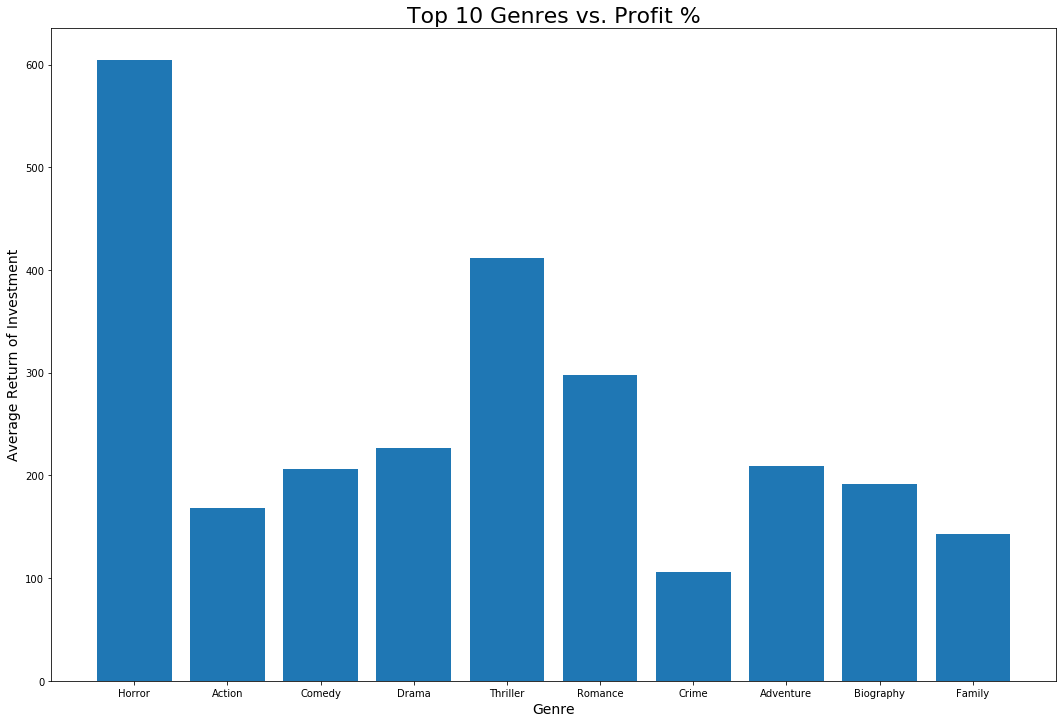

In [11]:
# The list of genres we want to iterate through and graph

list_of_genres = ['Horror', 'Action', 'Comedy', 'Drama', 'Thriller', 'Romance', 'Crime', 'Adventure', 'Biography', 'Family']

# Seperating by genre and creating a dictionary of average ROI, then converting to a series

genredf = func.create_genre_columns(maindf, maindf['genres'], list_of_genres)

gen_series = pd.Series(func.find_genre_profits(genredf, list_of_genres))



#Charting Genre vs. Profit % to see which Genre is most profitable
X = list(gen_series.index)
Y = gen_series
fig, ax = plt.subplots(figsize=(18,12))
plt.bar(X, Y)
ax.set_title("Top 10 Genres vs. Profit %", fontsize=22) 
ax.set_xlabel('Genre', fontsize = 14)
ax.set_ylabel('Average Return of Investment', fontsize = 14)
plt.show()

Since Horror seems to be by far the most profitable, followed by Thriller, we have some pretty solid conclusions about what kinds of movies to produce.

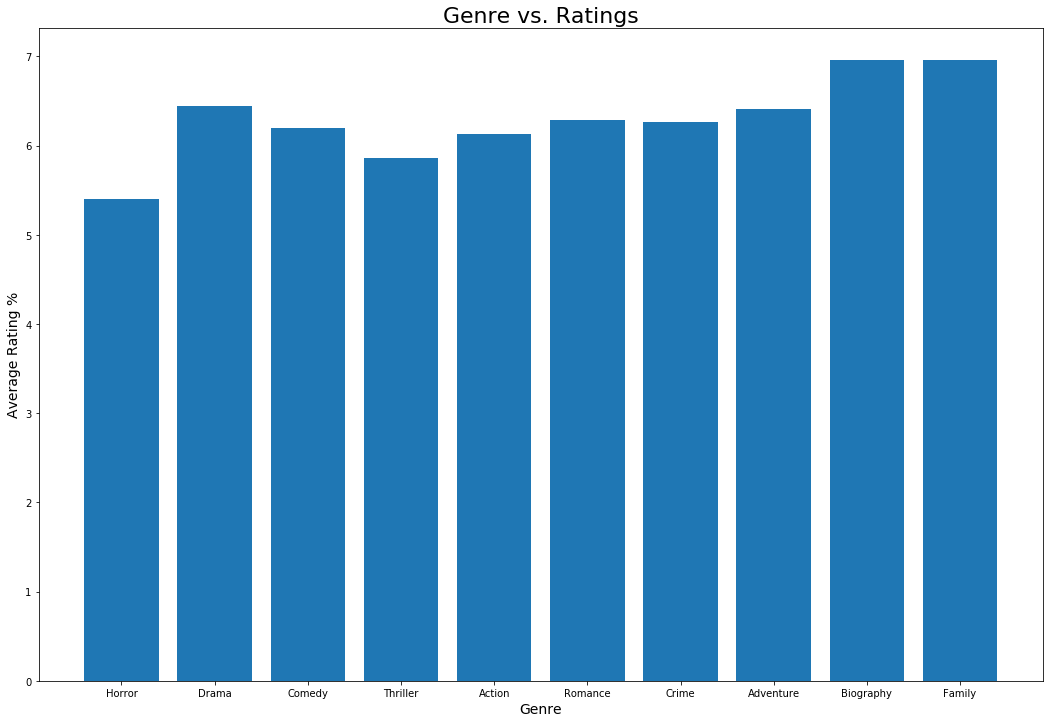

In [25]:
#Charting Genre vs. Rating to see which Genre receives highest ratings
X = ['Horror','Drama','Comedy','Thriller','Action','Romance','Crime','Adventure','Biography','Family']
Y = [horror_ratingavg,drama_ratingavg,comedy_ratingavg,thriller_ratingavg,action_ratingavg,romance_ratingavg,crime_ratingavg,adventure_ratingavg,biography_ratingavg,family_ratingavg]
fig, ax = plt.subplots(figsize=(18,12))
plt.bar(X, Y)
ax.set_title("Genre vs. Ratings", fontsize = 22) 
ax.set_xlabel('Genre', fontsize = 14)
ax.set_ylabel('Average Rating %', fontsize = 14)
plt.show()

Horror does seem to generate the lowest average ratings of all the genres we inspected, but because our correlation between ratings and profit is so small, we consider the ratings far less important.

## Phase 5-
### Conclusion

Based on the visualizations and calculations above, we've concluded that the best strategy to making profitable movies is to create horror or thriller titles with a budget ranging from 5mil to 50mil and a release schedule of every three months- January, April, July and October.

We look forward to seeing a variety of new horror titles from Microsoft. 